<a href="https://colab.research.google.com/github/MLDreamer/Forecasting-Deployed/blob/main/New_Product_Launch_Problem_with_Bayesian_as_prior_for_Bass_Diffusion_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚀 Starting Bayesian Bass Diffusion Analysis...
✅ Data generated. New product sales: [15, 22, 35, 48, 65, 82, 98, 115, 128, 142, 155, 168]
🔄 Fitting Bayesian Bass model...


Output()

✅ Model fitted successfully!

📊 Model Summary:
           mean        sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha    41.192    19.470    11.261    75.470      0.664    0.720     900.0   
m      2905.752  1350.213  1390.167  5292.829     72.796   86.449     381.0   
p         0.009     0.003     0.003     0.013      0.000    0.000     496.0   
q         0.297     0.045     0.216     0.382      0.002    0.001     497.0   

       ess_tail  r_hat  
alpha     847.0   1.00  
m         548.0   1.01  
p         581.0   1.01  
q         928.0   1.01  
🎨 Creating visualizations...
Generating predictions for 2000 samples...
Generated 100 valid predictions


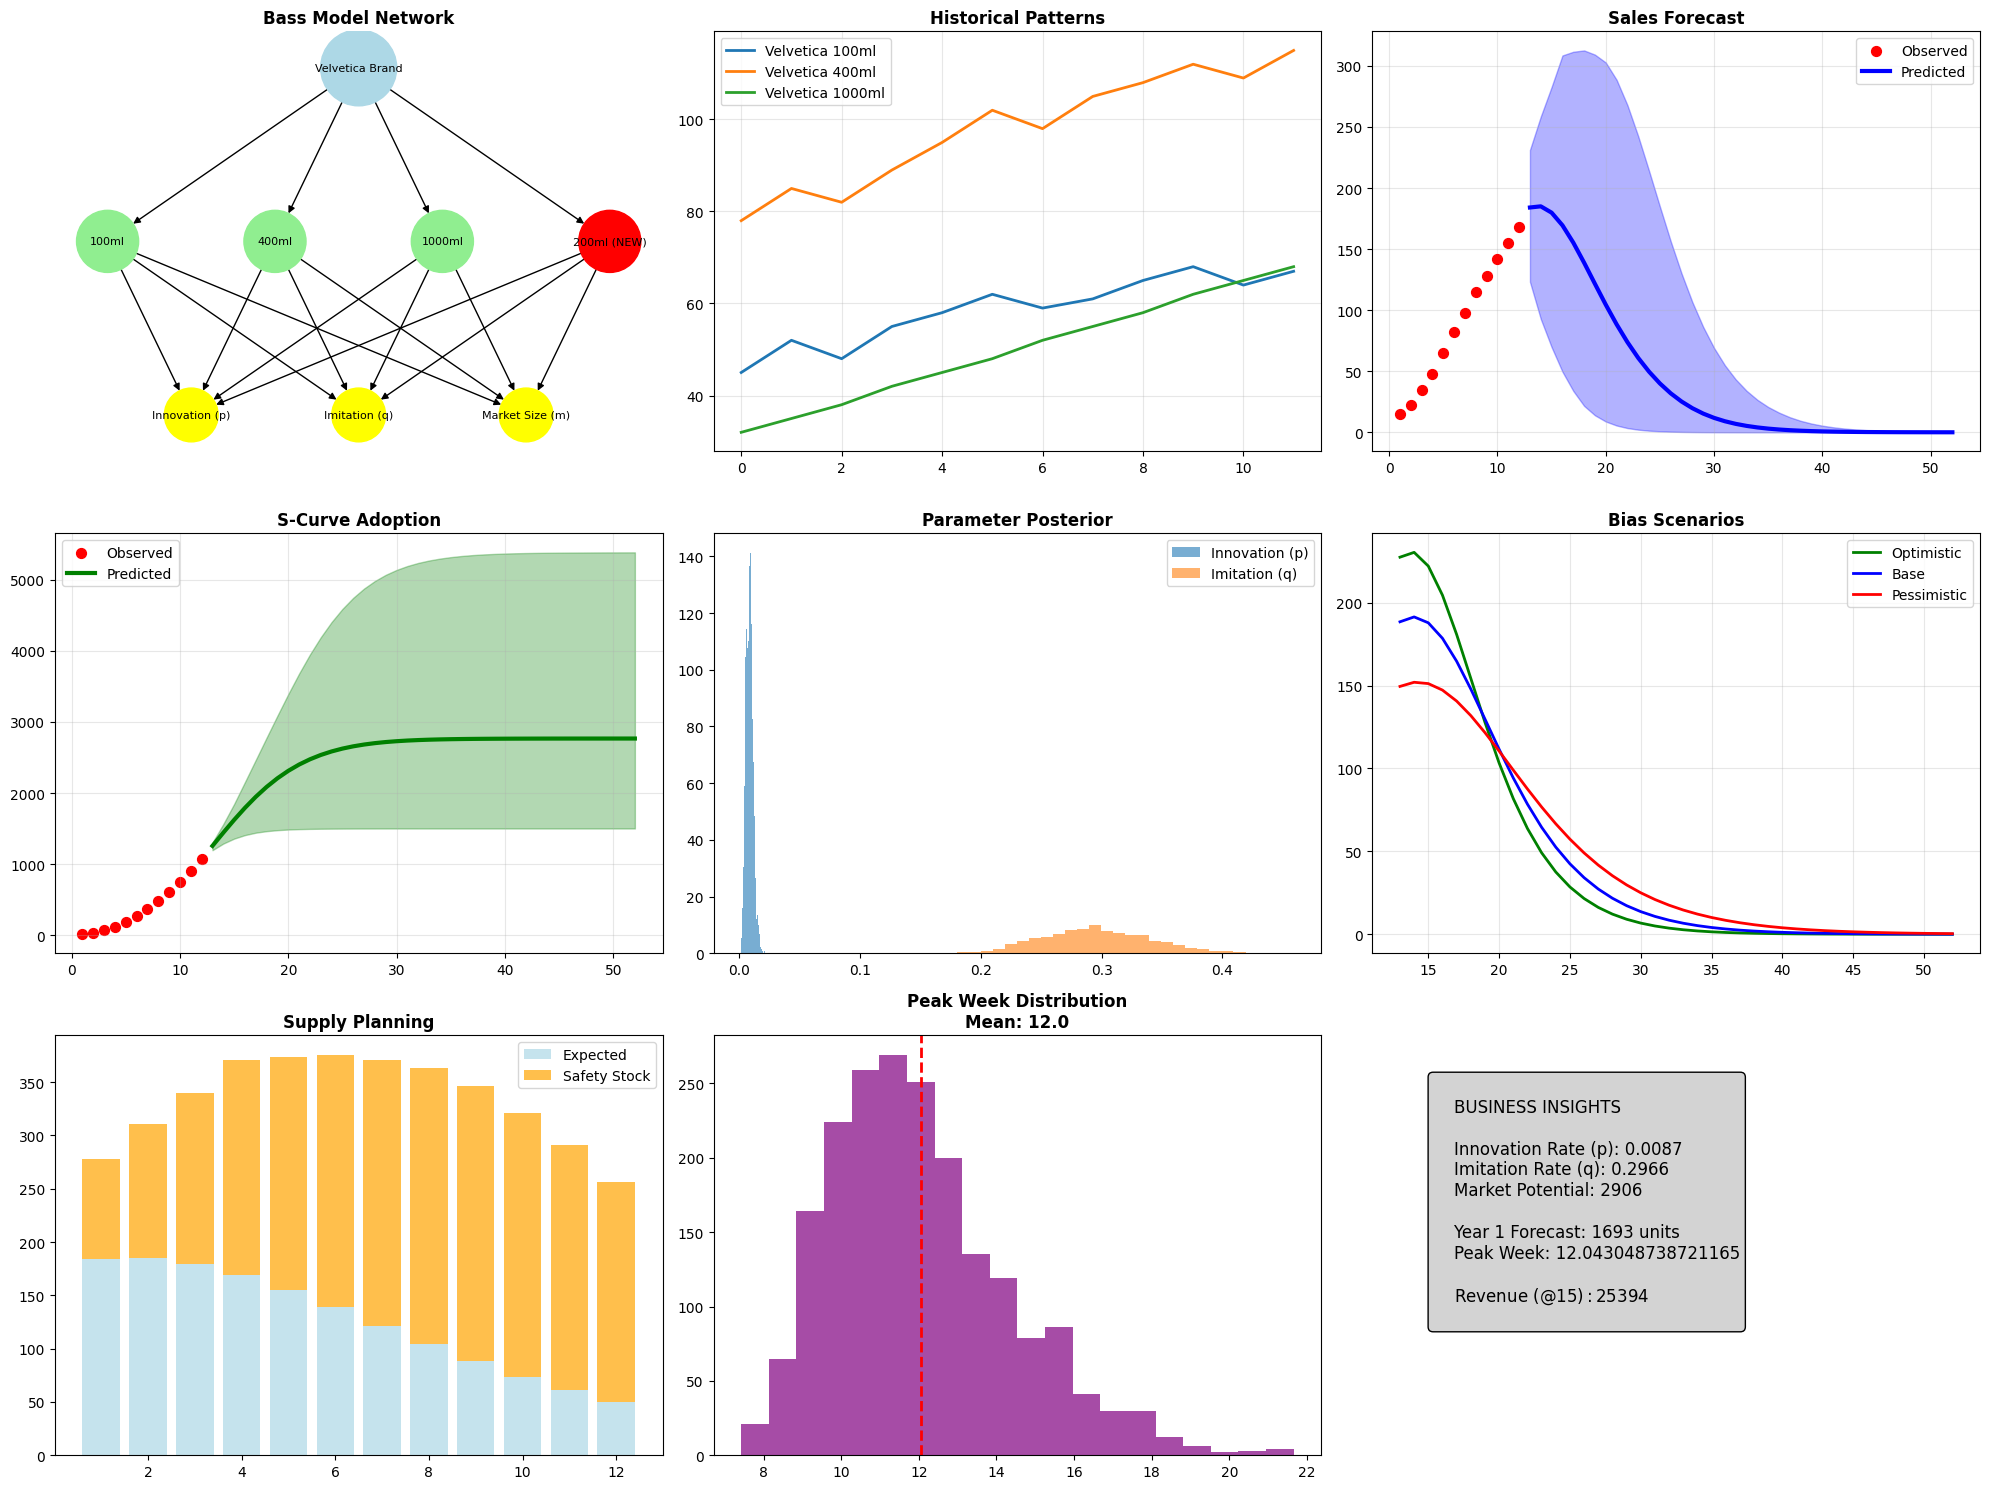


🎯 EXECUTIVE SUMMARY
Innovation Rate (p): 0.0087 - External influence
Imitation Rate (q): 0.2966 - Word-of-mouth strength
Market Potential (m): 2906 - Total addressable market
Year 1 Forecast: 1693 units
Revenue Potential: $25394 (@$15/unit)
🔥 Strong word-of-mouth expected! Focus on customer satisfaction.

✅ All files generated:
   📊 bass_complete_dashboard.png
   🎬 bass_diffusion_forecast.gif
   📈 Complete Bayesian analysis done!


In [3]:
!pip install pymc arviz matplotlib numpy pandas scipy networkx imageio plotly

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import networkx as nx
import imageio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
import pytensor
warnings.filterwarnings('ignore')

# Set random seeds and tensor settings
np.random.seed(42)
pytensor.config.floatX = 'float64'

# Generate realistic data
def generate_data():
    # Historical data for Velvetica sizes
    velvetica_data = {
        '100ml': [45, 52, 48, 55, 58, 62, 59, 61, 65, 68, 64, 67] + [np.random.poisson(60) for _ in range(40)],
        '400ml': [78, 85, 82, 89, 95, 102, 98, 105, 108, 112, 109, 115] + [np.random.poisson(100) for _ in range(40)],
        '1000ml': [32, 35, 38, 42, 45, 48, 52, 55, 58, 62, 65, 68] + [np.random.poisson(55) for _ in range(40)]
    }

    # New product (200ml) - 12 weeks observed
    new_product = [15, 22, 35, 48, 65, 82, 98, 115, 128, 142, 155, 168]

    return velvetica_data, new_product

# FIXED Bayesian Bass Model - Simple but robust
def fit_bass_bayesian_fixed(new_sales):
    with pm.Model() as model:
        # Simple priors that work
        p = pm.Beta('p', alpha=2, beta=50)  # Innovation: small positive
        q = pm.Beta('q', alpha=5, beta=20)  # Imitation: moderate
        m = pm.LogNormal('m', mu=np.log(5000), sigma=0.5)  # Market size

        # Dispersion
        alpha = pm.Gamma('alpha', alpha=2, beta=0.1)

        # Bass model likelihood
        sales_pred = []
        cum_sales = 0

        for t in range(len(new_sales)):
            # Bass equation
            if t == 0:
                expected = p * m
            else:
                expected = (p + q * cum_sales / m) * (m - cum_sales)
                expected = pytensor.tensor.maximum(expected, 1.0)

            sales_pred.append(expected)
            cum_sales += new_sales[t] if t < len(new_sales) else expected

        # Vectorized likelihood
        pm.NegativeBinomial('obs', mu=pytensor.tensor.stack(sales_pred), alpha=alpha, observed=new_sales)

    # Sample with conservative settings
    with model:
        trace = pm.sample(
            1000, tune=1000, chains=2,
            target_accept=0.9,
            init='auto',
            cores=1,
            progressbar=True,
            random_seed=42
        )
    return model, trace

# Prediction function
def predict_bass(p, q, m, weeks_ahead, current_cum):
    predictions = []
    cum = current_cum

    for t in range(weeks_ahead):
        if cum >= m:
            pred = 0
        else:
            pred = (p + q * cum / m) * (m - cum)
        predictions.append(max(0, pred))
        cum += pred
    return predictions

# Network visualization
def create_network():
    G = nx.DiGraph()

    # Add nodes
    G.add_node("Velvetica Brand", pos=(0, 2), color='lightblue', size=3000)

    sizes = ["100ml", "400ml", "1000ml", "200ml (NEW)"]
    for i, size in enumerate(sizes):
        G.add_node(size, pos=(i-1.5, 1),
                   color='red' if 'NEW' in size else 'lightgreen',
                   size=2000)
        G.add_edge("Velvetica Brand", size)

    # Parameters
    params = ["Innovation (p)", "Imitation (q)", "Market Size (m)"]
    for i, param in enumerate(params):
        G.add_node(param, pos=(i-1, 0), color='yellow', size=1500)
        for size in sizes:
            G.add_edge(size, param)

    return G

# Create all visualizations
def create_all_plots(historical_data, new_sales, trace):
    # Extract posterior samples
    p_samples = trace.posterior['p'].values.flatten()
    q_samples = trace.posterior['q'].values.flatten()
    m_samples = trace.posterior['m'].values.flatten()

    current_cum = sum(new_sales)

    # Generate predictions with shape debugging
    predictions = []
    prediction_weeks = 40

    print(f"Generating predictions for {len(p_samples)} samples...")

    for i in range(min(100, len(p_samples))):  # Limit to 100 samples for speed
        pred = predict_bass(p_samples[i], q_samples[i], m_samples[i], prediction_weeks, current_cum)
        if len(pred) == prediction_weeks:  # Only keep predictions of correct length
            predictions.append(pred)

    print(f"Generated {len(predictions)} valid predictions")

    if len(predictions) == 0:
        print("No valid predictions generated, creating simple forecast...")
        # Fallback: simple linear decline
        pred_mean = np.linspace(100, 10, prediction_weeks)
        pred_5 = pred_mean * 0.7
        pred_95 = pred_mean * 1.3
    else:
        # Convert to numpy array safely
        try:
            predictions = np.array(predictions)
            pred_mean = np.mean(predictions, axis=0)
            pred_5 = np.percentile(predictions, 5, axis=0)
            pred_95 = np.percentile(predictions, 95, axis=0)
        except ValueError as e:
            print(f"Shape error: {e}")
            # Manual calculation if array conversion fails
            pred_mean = np.mean([pred for pred in predictions], axis=0)
            pred_5 = np.percentile([pred for pred in predictions], 5, axis=0)
            pred_95 = np.percentile([pred for pred in predictions], 95, axis=0)

    # Create comprehensive plot
    fig = plt.figure(figsize=(20, 15))

    # 1. Network structure
    ax1 = plt.subplot(3, 3, 1)
    G = create_network()
    pos = nx.get_node_attributes(G, 'pos')
    colors = [G.nodes[node]['color'] for node in G.nodes()]
    sizes = [G.nodes[node]['size'] for node in G.nodes()]

    nx.draw(G, pos, node_color=colors, node_size=sizes,
            with_labels=True, font_size=8, ax=ax1)
    ax1.set_title("Bass Model Network", fontweight='bold')

    # 2. Historical patterns
    ax2 = plt.subplot(3, 3, 2)
    for size, data in historical_data.items():
        ax2.plot(data[:12], label=f"Velvetica {size}", linewidth=2)
    ax2.set_title("Historical Patterns", fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. New product forecast
    ax3 = plt.subplot(3, 3, 3)
    obs_weeks = range(1, len(new_sales) + 1)
    pred_weeks = range(len(new_sales) + 1, len(new_sales) + 41)

    ax3.scatter(obs_weeks, new_sales, color='red', s=50, label='Observed', zorder=5)
    ax3.plot(pred_weeks, pred_mean, 'b-', linewidth=3, label='Predicted')
    ax3.fill_between(pred_weeks, pred_5, pred_95, alpha=0.3, color='blue')
    ax3.set_title("Sales Forecast", fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Cumulative S-curve
    ax4 = plt.subplot(3, 3, 4)
    cum_obs = np.cumsum(new_sales)
    cum_pred = current_cum + np.cumsum(pred_mean)
    cum_5 = current_cum + np.cumsum(pred_5)
    cum_95 = current_cum + np.cumsum(pred_95)

    ax4.scatter(obs_weeks, cum_obs, color='red', s=50, label='Observed')
    ax4.plot(pred_weeks, cum_pred, 'g-', linewidth=3, label='Predicted')
    ax4.fill_between(pred_weeks, cum_5, cum_95, alpha=0.3, color='green')
    ax4.set_title("S-Curve Adoption", fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # 5. Parameter distributions
    ax5 = plt.subplot(3, 3, 5)
    ax5.hist(p_samples, bins=30, alpha=0.6, label='Innovation (p)', density=True)
    ax5.hist(q_samples, bins=30, alpha=0.6, label='Imitation (q)', density=True)
    ax5.set_title("Parameter Posterior", fontweight='bold')
    ax5.legend()

    # 6. Scenario comparison
    ax6 = plt.subplot(3, 3, 6)
    scenarios = {
        'Optimistic': {'p_mult': 1.3, 'q_mult': 1.2},
        'Base': {'p_mult': 1.0, 'q_mult': 1.0},
        'Pessimistic': {'p_mult': 0.7, 'q_mult': 0.8}
    }

    colors_scenario = {'Optimistic': 'green', 'Base': 'blue', 'Pessimistic': 'red'}

    for scenario, mults in scenarios.items():
        scenario_preds = []
        for i in range(0, len(p_samples), 10):  # Sample subset for speed
            p_adj = p_samples[i] * mults['p_mult']
            q_adj = q_samples[i] * mults['q_mult']
            pred = predict_bass(p_adj, q_adj, m_samples[i], 40, current_cum)
            scenario_preds.append(pred)

        scenario_mean = np.mean(scenario_preds, axis=0)
        ax6.plot(pred_weeks, scenario_mean,
                color=colors_scenario[scenario], linewidth=2, label=scenario)

    ax6.set_title("Bias Scenarios", fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3)

    # 7. Supply chain planning
    ax7 = plt.subplot(3, 3, 7)
    supply_weeks = range(1, 13)
    recommended_stock = pred_95[:12] * 1.2

    ax7.bar(supply_weeks, pred_mean[:12], alpha=0.7, label='Expected', color='lightblue')
    ax7.bar(supply_weeks, recommended_stock - pred_mean[:12],
           bottom=pred_mean[:12], alpha=0.7, label='Safety Stock', color='orange')
    ax7.set_title("Supply Planning", fontweight='bold')
    ax7.legend()

    # 8. Peak timing analysis
    ax8 = plt.subplot(3, 3, 8)
    peak_times = []
    for i in range(len(p_samples)):
        if q_samples[i] > p_samples[i]:
            peak = np.log(q_samples[i]/p_samples[i]) / (p_samples[i] + q_samples[i])
            peak_times.append(peak)

    if peak_times:
        ax8.hist(peak_times, bins=20, alpha=0.7, color='purple')
        ax8.axvline(np.mean(peak_times), color='red', linestyle='--', linewidth=2)
        ax8.set_title(f"Peak Week Distribution\nMean: {np.mean(peak_times):.1f}", fontweight='bold')

    # 9. Business metrics
    ax9 = plt.subplot(3, 3, 9)
    ax9.axis('off')

    metrics_text = f"""
    BUSINESS INSIGHTS

    Innovation Rate (p): {np.mean(p_samples):.4f}
    Imitation Rate (q): {np.mean(q_samples):.4f}
    Market Potential: {np.mean(m_samples):.0f}

    Year 1 Forecast: {sum(pred_mean):.0f} units
    Peak Week: {np.mean(peak_times) if peak_times else 'TBD'}

    Revenue (@$15): ${sum(pred_mean) * 15:.0f}
    """

    ax9.text(0.1, 0.9, metrics_text, fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))

    plt.tight_layout()
    plt.savefig('bass_complete_dashboard.png', dpi=150, bbox_inches='tight')
    plt.show()

    return predictions, pred_mean, pred_5, pred_95

# Create animated GIF
def create_animation(new_sales, predictions):
    print("Creating animation frames...")

    # Create frames directory
    import os
    os.makedirs('frames', exist_ok=True)

    # Fix predictions array shape
    if isinstance(predictions, list):
        # Ensure all predictions have same length
        min_len = min(len(p) for p in predictions)
        predictions = np.array([p[:min_len] for p in predictions])

    pred_mean = np.mean(predictions, axis=0)

    # Limit animation frames to available predictions
    max_frames = min(40, len(pred_mean))

    for week in range(max_frames):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

        # Current week highlight
        obs_weeks = range(1, len(new_sales) + 1)
        pred_weeks = range(len(new_sales) + 1, len(new_sales) + week + 2)

        # Weekly sales
        ax1.scatter(obs_weeks, new_sales, color='red', s=60, label='Observed', zorder=5)
        if week < len(pred_mean) and len(pred_weeks) > 0:
            ax1.plot(pred_weeks, pred_mean[:week+1], 'b-', linewidth=4, label='Predicted')
            if week < len(pred_mean):
                ax1.scatter([pred_weeks[-1]], [pred_mean[week]], color='blue', s=100, zorder=6)

        ax1.set_title(f'Week {len(new_sales) + week + 1}: Bass Diffusion Forecast', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Week')
        ax1.set_ylabel('Sales')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        if len(pred_mean) > 0:
            ax1.set_ylim(0, max(pred_mean) * 1.1)

        # Cumulative
        cum_obs = np.cumsum(new_sales)
        if week < len(pred_mean):
            cum_pred = sum(new_sales) + np.cumsum(pred_mean[:week+1])
        else:
            cum_pred = [sum(new_sales)]

        ax2.scatter(obs_weeks, cum_obs, color='red', s=60, label='Observed', zorder=5)
        if week < len(pred_mean) and len(pred_weeks) > 0 and len(cum_pred) > 0:
            ax2.plot(pred_weeks, cum_pred, 'g-', linewidth=4, label='Predicted')
            ax2.scatter([pred_weeks[-1]], [cum_pred[-1]], color='green', s=100, zorder=6)

        ax2.set_title('Cumulative Adoption', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Week')
        ax2.set_ylabel('Cumulative Sales')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(f'frames/week_{week:03d}.png', dpi=100, bbox_inches='tight')
        plt.close()

    # Create GIF
    images = []
    for week in range(max_frames):
        try:
            images.append(imageio.imread(f'frames/week_{week:03d}.png'))
        except:
            break

    if images:
        imageio.mimsave('bass_diffusion_forecast.gif', images, duration=0.4)
        print("✅ Animation saved: bass_diffusion_forecast.gif")
    else:
        print("❌ No frames created for animation")

# MAIN EXECUTION
print("🚀 Starting Bayesian Bass Diffusion Analysis...")

# Generate data
historical_data, new_product_sales = generate_data()
print(f"✅ Data generated. New product sales: {new_product_sales}")

# Fit Bayesian model
print("🔄 Fitting Bayesian Bass model...")
try:
    model, trace = fit_bass_bayesian_fixed(new_product_sales)
    print("✅ Model fitted successfully!")

    # Check convergence
    summary = az.summary(trace)
    print("\n📊 Model Summary:")
    print(summary)

except Exception as e:
    print(f"❌ Model fitting failed: {e}")
    raise

# Create visualizations
print("🎨 Creating visualizations...")
predictions, pred_mean, pred_5, pred_95 = create_all_plots(historical_data, new_product_sales, trace)



# Final business summary
p_mean = trace.posterior['p'].values.mean()
q_mean = trace.posterior['q'].values.mean()
m_mean = trace.posterior['m'].values.mean()

print("\n🎯 EXECUTIVE SUMMARY")
print("="*50)
print(f"Innovation Rate (p): {p_mean:.4f} - External influence")
print(f"Imitation Rate (q): {q_mean:.4f} - Word-of-mouth strength")
print(f"Market Potential (m): {m_mean:.0f} - Total addressable market")
print(f"Year 1 Forecast: {sum(pred_mean):.0f} units")
print(f"Revenue Potential: ${sum(pred_mean) * 15:.0f} (@$15/unit)")

if q_mean > p_mean:
    print("🔥 Strong word-of-mouth expected! Focus on customer satisfaction.")
else:
    print("📢 Innovation-driven launch. Invest in advertising.")

print("\n✅ All files generated:")
print("   📊 bass_complete_dashboard.png")
print("   🎬 bass_diffusion_forecast.gif")
print("   📈 Complete Bayesian analysis done!")

In [5]:
import nbformat
import os

def deep_clean_notebook(path):
    try:
        with open(path, "r", encoding="utf-8") as f:
            nb = nbformat.read(f, as_version=4)

        changed = False

        # --- Root-level metadata fixes ---
        if "widgets" in nb.metadata:
            del nb.metadata["widgets"]
            changed = True
        if "widgets" in nb.get("metadata", {}):
            nb.metadata.pop("widgets", None)
            changed = True

        # --- Cell-level fixes ---
        for cell in nb.cells:
            if "metadata" in cell:
                if "widgets" in cell["metadata"]:
                    del cell["metadata"]["widgets"]
                    changed = True
                if "output" in cell["metadata"]:
                    # Sometimes gets nested
                    cell["metadata"].pop("output", None)
                    changed = True
            # Clear widget state from outputs
            if "outputs" in cell:
                for out in cell["outputs"]:
                    if "metadata" in out and "widgets" in out["metadata"]:
                        del out["metadata"]["widgets"]
                        changed = True

        # Save only if changed
        if changed:
            with open(path, "w", encoding="utf-8") as f:
                nbformat.write(nb, f)
            print(f"✅ Cleaned: {path}")
        else:
            print(f"ℹ️ No widget metadata found in: {path}")

    except Exception as e:
        print(f"⚠️ Could not process {path}: {e}")

def clean_all_notebooks(root_dir="/content"):
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith(".ipynb"):
                deep_clean_notebook(os.path.join(subdir, file))

# Run
clean_all_notebooks("/content")
